In [5]:
from torchvision import models
from torchvision import transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
from torchmetrics.functional import total_variation
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_dog_image():
    """Prepares the image to be fed into the model."""
    img = Image.open("examples/dog.jpg")
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
     )])
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t


def rotate_270(im):
    return np.rot90(im, 3)

In [7]:
class ImageLayer(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.weight = nn.Parameter(torch.rand((in_channels, 224, 224), requires_grad=True))
        
    def init_layer(self, image_batch):
        self.weight.data = image_batch[0, ...]
    
    def forward(self):
        return torch.unsqueeze(torch.mul(1, self.weight), 0)
    

class DeepDream(nn.Module):
    def __init__(self, targets):
        super().__init__()
        self.classifier = models.vgg16(pretrained=True)
        self.modify = ImageLayer()
        self.classifier.eval()
        for param in self.classifier.parameters():
            param.requires_grad = False
        self.targets = targets
        
    def get_image_numpy(self):
        """Converts the image to numpy array that can be displayed."""
        im = self.modify()
        im_numpy = rotate_270(np.squeeze(im.detach().numpy()).T)
        return im_numpy
    
    def init_image(self, image_batch):
        self.modify.init_layer(image_batch)
    
    def forward(self):
        """Return selected activations of the last layer."""
        modified = self.modify()
        predictions = self.classifier(modified)
        activations = predictions[:, self.targets]
        return activations

In [26]:
def run_deepdream(targets, init_image=False):
    """Maximize selected activations."""
    net = DeepDream(targets)
    if init_image:
        net.init_image(prepare_dog_image())
    optimizer = optim.Adam(net.parameters(), 0.01)
    regularization_coeff = 0.1
    images = []
    for epoch in tqdm(range(30)): #500
        optimizer.zero_grad()
        pred = net()
        im = net.modify()
        im_to_display = net.get_image_numpy()
        var = total_variation(im, reduction=None)
        loss_1 = -torch.mean(pred)
        loss_2 = regularization_coeff * var
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()
        if not epoch%10:
            images.append(im_to_display)
    return images

# class_images = {}

# for class_idx in [84, 187, 8, 71]:
#     class_images[class_idx] = run_deepdream(class_idx)


# with open("class_images", "wb") as f:
#     pickle.dump(class_images, f)

    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:50<00:00,  1.37s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


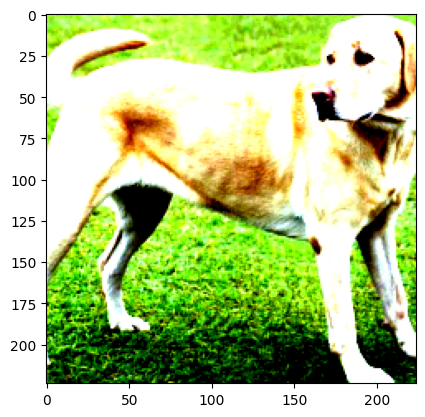

In [29]:
plt.imshow(run_deepdream(list(range(1000)), init_image=True)[-30])

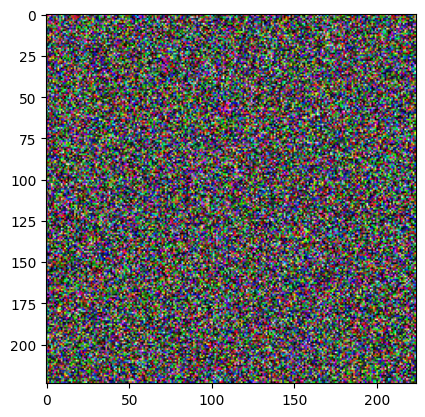

In [16]:
plt.imshow((class_images[71][-1])**2)

<IPython.core.display.Javascript object>


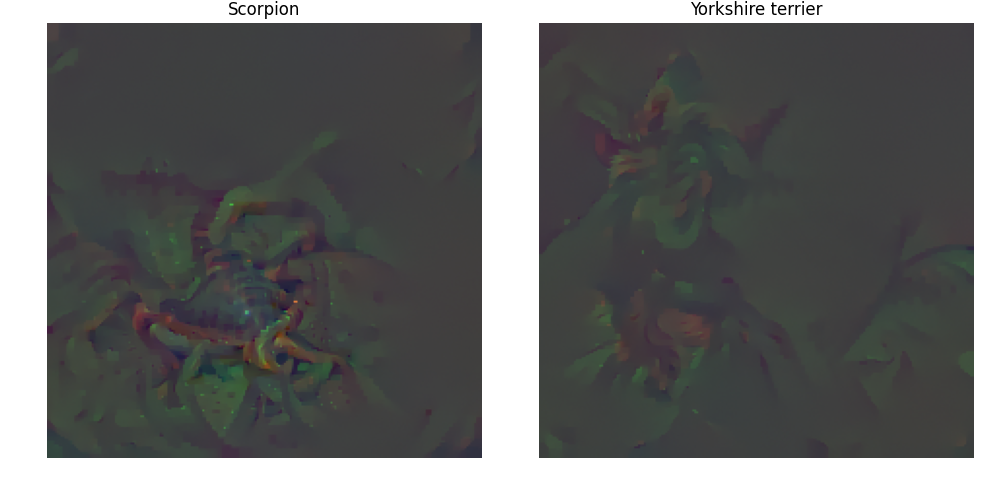

In [367]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter 
%matplotlib notebook
# fig, ax = plt.subplots()
xdata, ydata = [], []
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
axs[0].axis('off')
axs[1].axis('off')
ln1 = axs[0].imshow(class_images[71][0]**2)
ln2 = axs[1].imshow(class_images[187][0]**2)
axs[0].set_title("Scorpion")
axs[1].set_title("Yorkshire terrier")

def init():
#     ax.set_xlim(0, 2*np.pi)
#     ax.set_ylim(-1, 1)
    return ln1, ln2

def update(data):
    frame1, frame2 = data
#     xdata.append(frame)
#     ydata.append(np.sin(frame))
    ln1.set_data(frame1**2)
    ln2.set_data(frame2**2)
    return ln,

data_gen = ((frame1, frame2) for frame1, frame2 in zip(class_images[71], class_images[187]))

ani = FuncAnimation(fig, update, frames=data_gen, save_count=1000,
                    init_func=init, blit=True)

writergif = PillowWriter(fps = 5)
ani.save('scorpio_dog.gif', writer=writergif)

# plt.show()

In [263]:
im = net.modify()
# net()
def rotate(im):
    return np.rot90(np.rot90(np.rot90(im)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


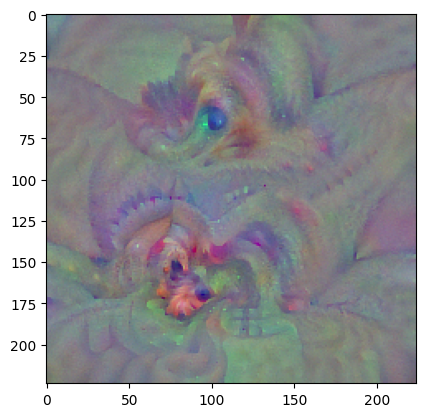

In [264]:
plt.imshow(rotate(np.squeeze(im.detach().numpy()).T))
# plt.imshow(images[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


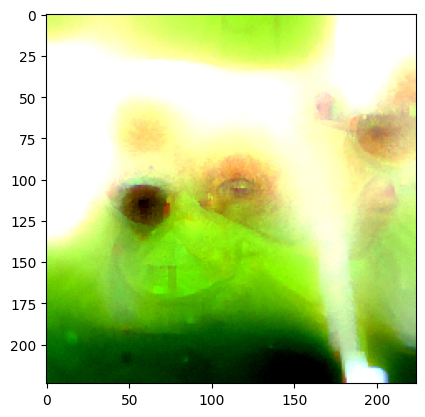

In [79]:
plt.imshow(rotate(np.squeeze(batch_t.detach().numpy()).T))

In [45]:
def revert_processing(img):
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    img = (img * std) + mean  # de-normalize
    img = np.clip(img, 0., 1.)  # make sure it's in the [0, 1] range
    return img

# good_enough = np.load("good_enough.npy")
# good_enough = (good_enough)
# im_org = revert_processing(rotate(img_t.numpy().T))

In [145]:
good_enough.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


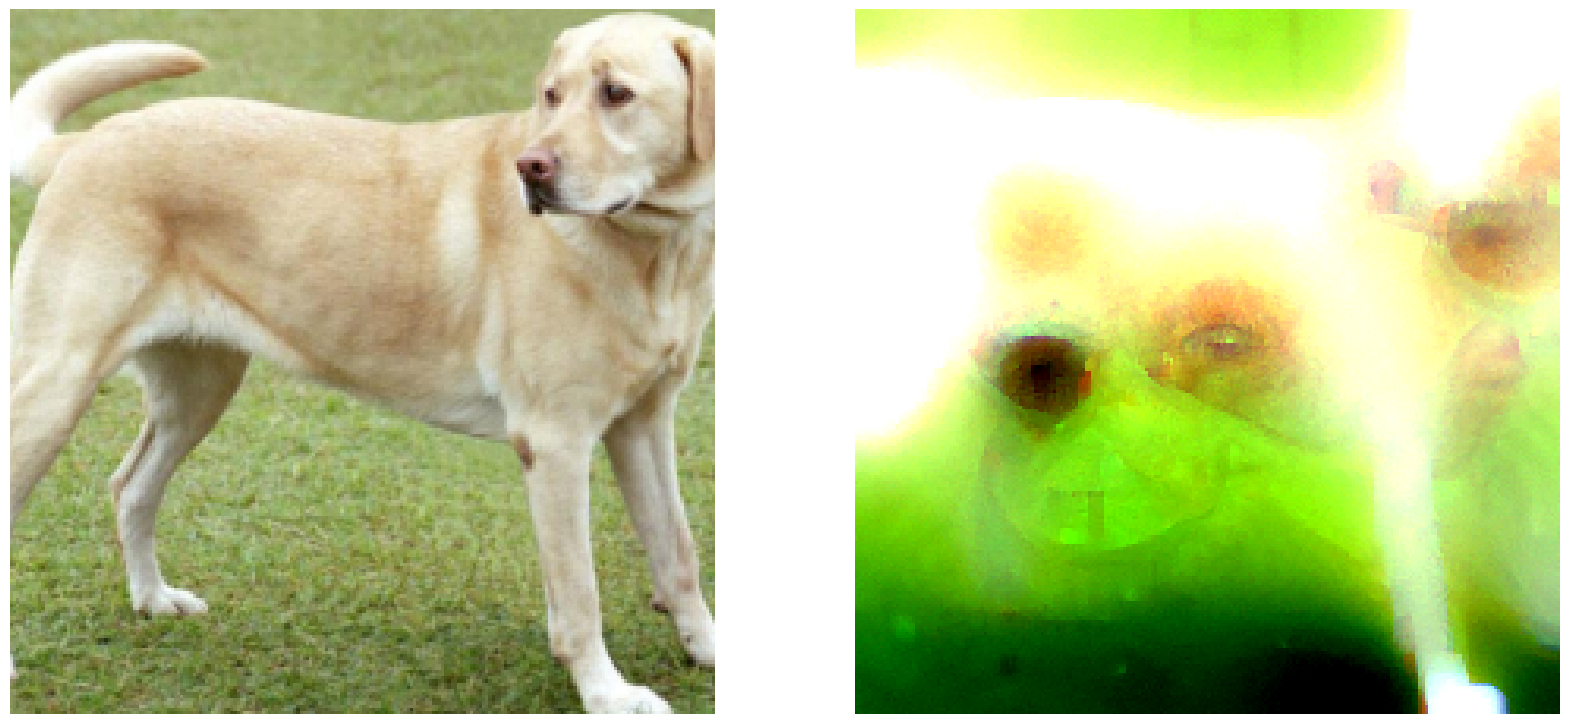

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(im_org)
axs[1].imshow(good_enough)
axs[0].set_axis_off()
axs[1].set_axis_off()